**Constantes**

Tamanho da sequência utilizada, tamanho da janela, frequência de _cutoff_, tamanho de lote, etc.

In [1]:
BASE_VALUE = 'depth'
BATCH_SIZE = 32
DATA_FOLDER = '../../data'
DENSE_ACTIVATION_FUNCTION = 'linear'
EARLY_STOP_EPOCH = 66
EARLY_STOP_PATIENCE = 36
EPOCHS = 200
INITIAL_LEARNING_RATE = 0.001
LEARNING_RATE_REDUCER_FACTOR = 0.5
LEARNING_RATE_REDUCER_PATIENCE = 16
LSTM_COUNT = [8, 4]
NORMALIZE = True
NOTEBOOK_NAME = '0_first_try'
PREDICTED_VALUE = 'discharge'
SEQUENCE_GAP = 5
SEQUENCE_SIZE = 10
TEST_SPLIT_FACTOR = 4

In [2]:
PLOT_TITLE = f'{BASE_VALUE} -> {PREDICTED_VALUE}'

In [3]:
from keras.callbacks import ReduceLROnPlateau
from tensorflow.python.platform import tf_logging as logging


class ReduceLRBacktrack(ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                            self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best):  # not new best
            if not self.in_cooldown():  # and we're not in cooldown
                if self.wait+1 >= self.patience:  # going to reduce lr
                    # load best model so far
                    print("Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs)  # actually reduce LR

2023-11-11 02:15:25.454905: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-11 02:15:25.485959: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 02:15:25.485985: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 02:15:25.486006: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 02:15:25.491196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-11 02:15:25.491570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Estado para reproduzir os mesmos resultados

In [4]:
from keras.utils import set_random_seed

set_random_seed(42)

# Preparação dos dados

Carregando o arquivo .csv que contém os dados de altura da lâmina e vazão.

In [5]:
import pandas as pd

In [6]:
unified_df = pd.read_csv(f'{DATA_FOLDER}/breach_simplified.csv')
display(unified_df.head())
unified = unified_df.values

,water_depth,inlet_discharge
0,10.000000,0.000000e+00
1,9.999995,0.000000e+00
2,9.999986,4.619332e-08
3,9.999972,1.847729e-07
4,9.999953,4.619311e-07


## Normalização

In [7]:
from sklearn.preprocessing import MinMaxScaler

unified_scaler = MinMaxScaler()
water_depth_scaler = MinMaxScaler()
inlet_discharge_scaler = MinMaxScaler()
water_depth_scaler.fit(unified[:, 0].reshape(-1, 1))
inlet_discharge_scaler.fit(unified[:, 1].reshape(-1, 1))
unified_scaler.fit(unified)

MinMaxScaler()

In [8]:
if NORMALIZE:
    if PREDICTED_VALUE == 'depth':
        OUTPUT_SCALER = water_depth_scaler
    elif PREDICTED_VALUE == 'discharge':
        OUTPUT_SCALER = inlet_discharge_scaler
    elif PREDICTED_VALUE == 'both':
        OUTPUT_SCALER = unified_scaler
    else:
        raise ValueError(f'PREDICTED_VALUE must be one of [depth, discharge, both], got {PREDICTED_VALUE}')
    unified = unified_scaler.transform(unified)

## Estrutura dos dados de treinamento

In [9]:
# Obtendo índices lower..upper
i = 0
lower = list()
upper = list()
while i + SEQUENCE_SIZE < len(unified):
    lower.append(i)
    upper.append(i + SEQUENCE_SIZE)
    print(f"[{i}, {i + SEQUENCE_SIZE})")
    i += SEQUENCE_GAP

[0, 10)
[5, 15)
[10, 20)
[15, 25)
[20, 30)
[25, 35)
[30, 40)
[35, 45)
[40, 50)
[45, 55)
[50, 60)
[55, 65)
[60, 70)
[65, 75)
[70, 80)
[75, 85)
[80, 90)
[85, 95)
[90, 100)
[95, 105)
[100, 110)
[105, 115)
[110, 120)
[115, 125)
[120, 130)
[125, 135)
[130, 140)
[135, 145)
[140, 150)
[145, 155)
[150, 160)
[155, 165)
[160, 170)
[165, 175)
[170, 180)
[175, 185)
[180, 190)
[185, 195)
[190, 200)
[195, 205)
[200, 210)
[205, 215)
[210, 220)
[215, 225)
[220, 230)
[225, 235)
[230, 240)
[235, 245)
[240, 250)
[245, 255)
[250, 260)
[255, 265)
[260, 270)
[265, 275)
[270, 280)
[275, 285)
[280, 290)
[285, 295)
[290, 300)
[295, 305)
[300, 310)
[305, 315)
[310, 320)
[315, 325)
[320, 330)
[325, 335)
[330, 340)
[335, 345)
[340, 350)
[345, 355)
[350, 360)
[355, 365)
[360, 370)
[365, 375)
[370, 380)
[375, 385)
[380, 390)
[385, 395)
[390, 400)
[395, 405)
[400, 410)
[405, 415)
[410, 420)
[415, 425)
[420, 430)
[425, 435)
[430, 440)
[435, 445)
[440, 450)
[445, 455)
[450, 460)
[455, 465)
[460, 470)
[465, 475)
[470, 

Construindo sequência de inputs e outputs utilizadas pela rede.

No caso desse notebook:

- Input: Altura da lâmina
- Output: Altura da lâmina

In [10]:
import numpy as np

number_of_sequences = len(lower)
display("Quantidade de sequências", number_of_sequences)

TRAINING_SIZE = int(number_of_sequences * (1 - 1 / TEST_SPLIT_FACTOR))
display("Quantidade de sequências de treinamento", TRAINING_SIZE)

inputs = np.zeros((number_of_sequences, SEQUENCE_SIZE, 1))
if PREDICTED_VALUE == 'both':
    outputs = np.zeros((number_of_sequences, SEQUENCE_SIZE, 2))
elif PREDICTED_VALUE == 'depth' or PREDICTED_VALUE == 'discharge':
    outputs = np.zeros((number_of_sequences, 1))
else:
    raise ValueError(f'PREDICTED_VALUE must be one of [depth, discharge, both], got {PREDICTED_VALUE}')
for i in range(number_of_sequences):
    if BASE_VALUE == 'depth':
        inputs[i, :] = unified[lower[i]:upper[i], 0].reshape(-1, 1)
    elif BASE_VALUE == 'discharge':
        inputs[i, :] = unified[lower[i]:upper[i], 1].reshape(-1, 1)
    elif BASE_VALUE == 'both':
        inputs[i, :] = unified[lower[i]:upper[i], :]
    else:
        raise ValueError(f'BASE_VALUE must be one of [depth, discharge, both], got {BASE_VALUE}')
    if PREDICTED_VALUE == 'both':
        outputs[i, :] = unified[upper[i], :]
    elif PREDICTED_VALUE == 'depth':
        outputs[i, :] = unified[upper[i], 0]
    elif PREDICTED_VALUE == 'discharge':
        outputs[i, :] = unified[upper[i], 1]
    else:
        raise ValueError(f'PREDICTED_VALUE must be one of [depth, discharge, both], got {PREDICTED_VALUE}')

inputs_train = inputs[:TRAINING_SIZE]
outputs_train = outputs[:TRAINING_SIZE]
inputs_test = inputs[TRAINING_SIZE:]
outputs_test = outputs[TRAINING_SIZE:]
display("Shapes", inputs_train.shape, outputs_train.shape,
        inputs_test.shape, outputs_test.shape)

'Quantidade de sequências'

3999

'Quantidade de sequências de treinamento'

2999

'Shapes'

(2999, 10, 1)

(2999, 1)

(1000, 10, 1)

(1000, 1)

# Rede neural e treinamento (Adam)

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, InputLayer, Dense
from keras.optimizers import Adam
from keras.utils import plot_model
import os

if os.path.exists(f'{NOTEBOOK_NAME}/model.png'):
    os.remove(f'{NOTEBOOK_NAME}/model.png')

model = Sequential(name=NOTEBOOK_NAME)
model.add(InputLayer(input_shape=((None, 1)), name='input_layer'))
for i, cell in enumerate(LSTM_COUNT[:-1]):
    model.add(LSTM(cell, return_sequences=True, name=f'lstm_layer_{i + 1}'))
model.add(LSTM(LSTM_COUNT[-1], name=f'lstm_layer_{len(LSTM_COUNT)}'))
model.add(Dense(1, DENSE_ACTIVATION_FUNCTION, name=DENSE_ACTIVATION_FUNCTION))
model.summary()
opt = Adam(learning_rate=INITIAL_LEARNING_RATE, amsgrad=True)

if not os.path.exists(NOTEBOOK_NAME):
    os.mkdir(NOTEBOOK_NAME)
plot_model(model, f'{NOTEBOOK_NAME}/model.png', show_shapes=True)
model.compile(loss='mae', optimizer=opt)

2023-11-11 02:15:27.509126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 02:15:27.509512: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "0_first_try"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer_1 (LSTM)         (None, None, 8)           320       
                                                                 
 lstm_layer_2 (LSTM)         (None, 4)                 208       
                                                                 
 linear (Dense)              (None, 1)                 5         
                                                                 
Total params: 533 (2.08 KB)
Trainable params: 533 (2.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

history = model.fit(
    inputs_train, outputs_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    shuffle=True,
    validation_batch_size=BATCH_SIZE//2,
    validation_split=0.15,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE,
                      verbose=1, restore_best_weights=True, start_from_epoch=EARLY_STOP_EPOCH),
        ModelCheckpoint(f'{NOTEBOOK_NAME}/model_adam.h5',
                        save_best_only=True, save_weights_only=True),
        ReduceLRBacktrack(f'{NOTEBOOK_NAME}/model_adam.h5',
                          monitor='val_loss', patience=LEARNING_RATE_REDUCER_PATIENCE, factor=LEARNING_RATE_REDUCER_FACTOR, verbose=1)
    ]
)
# Recuperando melhor modelo
model.load_weights(f'{NOTEBOOK_NAME}/model_adam.h5')

Epoch 1/200
80/80 [==============================] - 4s 13ms/step - loss: 0.4137 - val_loss: 0.0554 - lr: 0.0010
Epoch 2/200
80/80 [==============================] - 0s 5ms/step - loss: 0.0175 - val_loss: 0.0061 - lr: 0.0010
Epoch 3/200
80/80 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0073 - lr: 0.0010
Epoch 4/200
80/80 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0079 - lr: 0.0010
Epoch 5/200
80/80 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0023 - lr: 0.0010
Epoch 6/200
80/80 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0064 - lr: 0.0010
Epoch 7/200
80/80 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0039 - lr: 0.0010
Epoch 8/200
80/80 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0033 - lr: 0.0010
Epoch 9/200
80/80 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0038 - lr

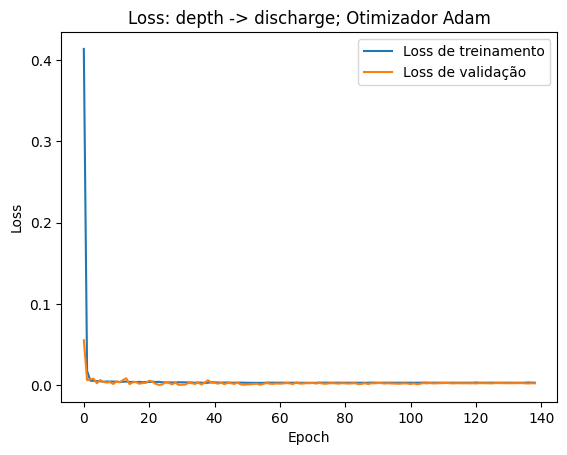

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss de treinamento')
plt.plot(history.history['val_loss'], label='Loss de validação')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title(f'Loss: {PLOT_TITLE}; Otimizador Adam')
plt.savefig(f'{NOTEBOOK_NAME}/loss_adam.png')

## Resultados obtidos

32/32 [==============================] - 0s 1ms/step


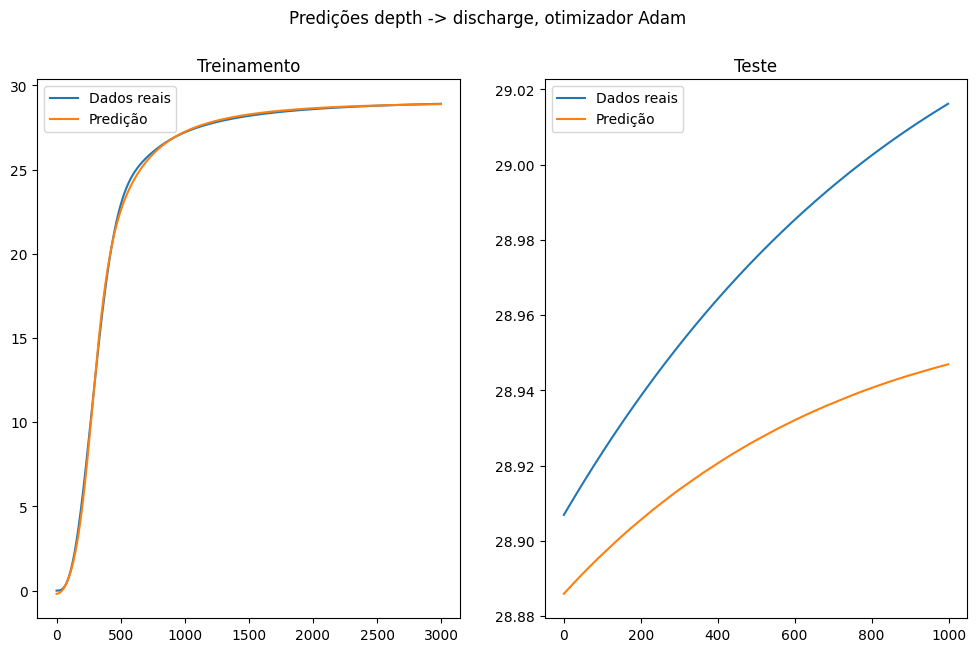

In [14]:
predictions_train = model.predict(inputs_train)
predictions_test = model.predict(inputs_test)
if NORMALIZE:
    predictions_train = OUTPUT_SCALER.inverse_transform(predictions_train)
    predictions_test = OUTPUT_SCALER.inverse_transform(predictions_test)
    temp_train = OUTPUT_SCALER.inverse_transform(outputs_train)
    temp_test = OUTPUT_SCALER.inverse_transform(outputs_test)
else:
    temp_train = outputs_train
    temp_test = outputs_test

fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].plot(temp_train, label='Dados reais')
ax[0].plot(predictions_train, label='Predição')
ax[0].legend()
ax[0].set_title('Treinamento')

ax[1].plot(temp_test, label='Dados reais')
ax[1].plot(predictions_test, label='Predição')
ax[1].legend()
ax[1].set_title('Teste')

fig.suptitle(f'Predições {PLOT_TITLE}, otimizador Adam')
plt.savefig(f'{NOTEBOOK_NAME}/predictions_adam.png')

# Rede neural e treinamento (SGD)

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, InputLayer, Dense
from keras.optimizers import SGD

model = Sequential(name=NOTEBOOK_NAME)
model.add(InputLayer(input_shape=((None, 1)), name='input_layer'))
for i, cell in enumerate(LSTM_COUNT[:-1]):
    model.add(LSTM(cell, return_sequences=True, name=f'lstm_layer_{i + 1}'))
model.add(LSTM(LSTM_COUNT[-1], name=f'lstm_layer_{len(LSTM_COUNT)}'))
model.add(Dense(1, DENSE_ACTIVATION_FUNCTION, name=DENSE_ACTIVATION_FUNCTION))
model.summary()
opt = SGD(learning_rate=INITIAL_LEARNING_RATE, momentum=0.9)
model.compile(loss='mae', optimizer=opt)

Model: "0_first_try"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer_1 (LSTM)         (None, None, 8)           320       
                                                                 
 lstm_layer_2 (LSTM)         (None, 4)                 208       
                                                                 
 linear (Dense)              (None, 1)                 5         
                                                                 
Total params: 533 (2.08 KB)
Trainable params: 533 (2.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

history = model.fit(
    inputs_train, outputs_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    shuffle=True,
    validation_batch_size=BATCH_SIZE//2,
    validation_split=0.15,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE,
                      verbose=1, restore_best_weights=True, start_from_epoch=EARLY_STOP_EPOCH),
        ModelCheckpoint(f'{NOTEBOOK_NAME}/model_sgd.h5',
                        save_best_only=True, save_weights_only=True),
        ReduceLRBacktrack(f'{NOTEBOOK_NAME}/model_sgd.h5',
                          monitor='val_loss', patience=LEARNING_RATE_REDUCER_PATIENCE, factor=LEARNING_RATE_REDUCER_FACTOR, verbose=1)
    ]
)
# Recuperando melhor modelo
model.load_weights(f'{NOTEBOOK_NAME}/model_sgd.h5')

Epoch 1/200
80/80 [==============================] - 3s 11ms/step - loss: 0.3434 - val_loss: 0.0329 - lr: 0.0010
Epoch 2/200
80/80 [==============================] - 0s 5ms/step - loss: 0.1425 - val_loss: 0.0283 - lr: 0.0010
Epoch 3/200
80/80 [==============================] - 0s 4ms/step - loss: 0.1340 - val_loss: 0.0162 - lr: 0.0010
Epoch 4/200
80/80 [==============================] - 0s 4ms/step - loss: 0.1228 - val_loss: 0.0129 - lr: 0.0010
Epoch 5/200
80/80 [==============================] - 0s 5ms/step - loss: 0.1058 - val_loss: 0.0042 - lr: 0.0010
Epoch 6/200
80/80 [==============================] - 0s 4ms/step - loss: 0.0817 - val_loss: 0.0038 - lr: 0.0010
Epoch 7/200
80/80 [==============================] - 0s 4ms/step - loss: 0.0599 - val_loss: 0.0016 - lr: 0.0010
Epoch 8/200
80/80 [==============================] - 0s 4ms/step - loss: 0.0402 - val_loss: 9.5279e-06 - lr: 0.0010
Epoch 9/200
80/80 [==============================] - 0s 4ms/step - loss: 0.0217 - val_loss: 0.0037 

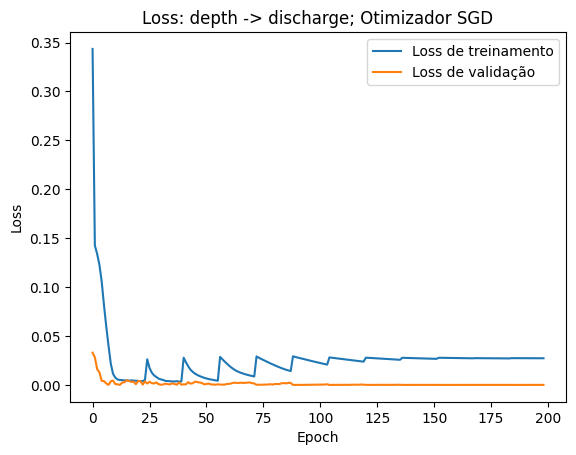

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss de treinamento')
plt.plot(history.history['val_loss'], label='Loss de validação')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title(f'Loss: {PLOT_TITLE}; Otimizador SGD')
plt.savefig(f'{NOTEBOOK_NAME}/loss_sgd.png')

## Resultados obtidos

Comparando predições para as sequências separadas para teste

Dados de treinamento: primeiro a rede precisa ser capaz de apresentar um desempenho satisfatório para os dados que foram utilizados em seu treinamento...

32/32 [==============================] - 0s 1ms/step


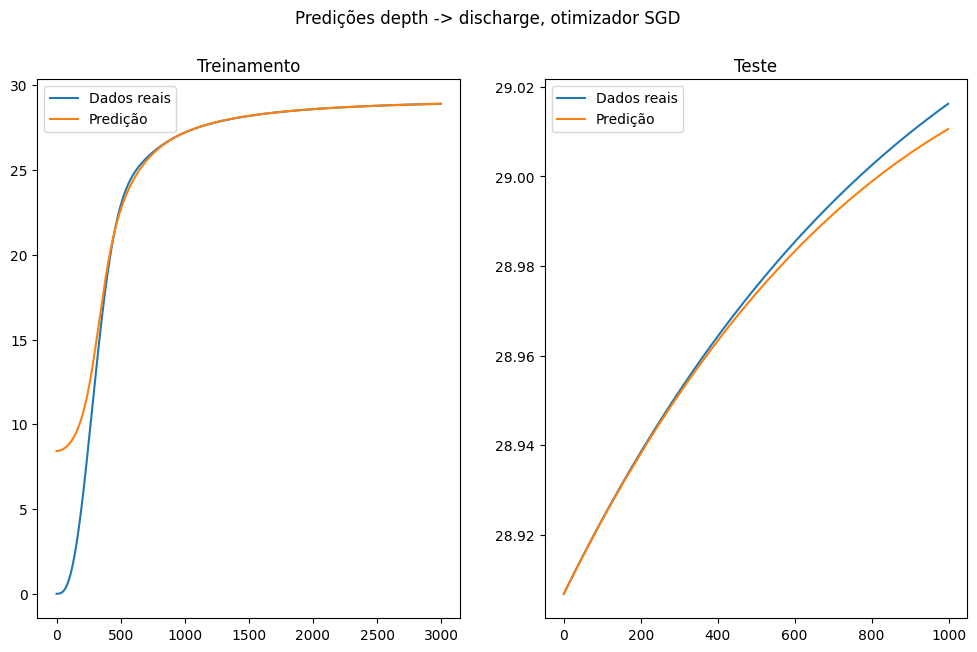

In [18]:
predictions_train = model.predict(inputs_train)
predictions_test = model.predict(inputs_test)
if NORMALIZE:
    predictions_train = OUTPUT_SCALER.inverse_transform(predictions_train)
    predictions_test = OUTPUT_SCALER.inverse_transform(predictions_test)
    temp_train = OUTPUT_SCALER.inverse_transform(outputs_train)
    temp_test = OUTPUT_SCALER.inverse_transform(outputs_test)
else:
    temp_train = outputs_train
    temp_test = outputs_test

fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].plot(temp_train, label='Dados reais')
ax[0].plot(predictions_train, label='Predição')
ax[0].legend()
ax[0].set_title('Treinamento')

ax[1].plot(temp_test, label='Dados reais')
ax[1].plot(predictions_test, label='Predição')
ax[1].legend()
ax[1].set_title('Teste')

fig.suptitle(f'Predições {PLOT_TITLE}, otimizador SGD')
plt.savefig(f'{NOTEBOOK_NAME}/predictions_sgd.png')